# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration 
- Triaxial Angular velocity from the gyroscope 
- A 561-feature vector with time and frequency domain variables 
- The activity label 

More information about the features are available on the website linked above.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts.
* Determine if the floating point values need to be scaled.
* Determine the breakdown of each activity.
* Encode the activity label as an integer.


In [3]:
### BEGIN SOLUTION
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data columns are all floats except for the activity label.


In [4]:
data.dtypes.value_counts()

float64    561
str          1
Name: count, dtype: int64

In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                    str
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [6]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [7]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [8]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(10)
### END SOLUTION

9820    0
1034    1
1875    4
5028    4
4950    0
3164    0
3124    1
5092    2
6141    0
1985    3
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values.
* Identify those that are most correlated (either positively or negatively).


In [14]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr() # type: ignore

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

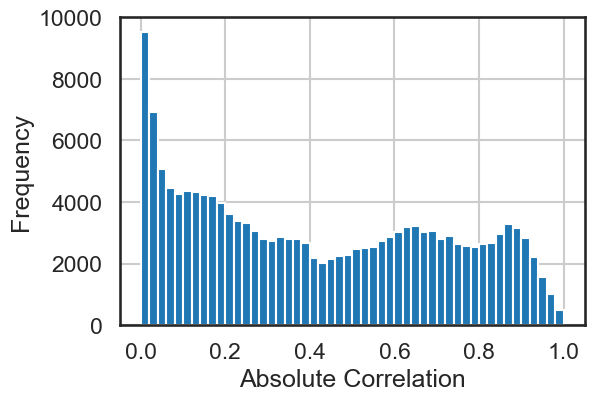

In [22]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(6, 4))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [32]:
# The most highly correlated values
corr_values.sort_values('abs_correlation', ascending=False)[corr_values['abs_correlation'] > 0.8]
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
115223,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
118595,tBodyAccMag-arCoeff()3,tGravityAccMag-arCoeff()3,1.000000,1.000000
116909,tBodyAccMag-entropy(),tGravityAccMag-entropy(),1.000000,1.000000
119711,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
114661,tBodyAccMag-min(),tGravityAccMag-min(),1.000000,1.000000
...,...,...,...,...
10066,tBodyAcc-energy()-Y,fBodyBodyGyroMag-std(),0.800024,0.800024
55709,tBodyAccJerk-iqr()-X,tBodyGyroJerk-max()-Y,0.800019,0.800019
151896,fBodyAcc-std()-Z,fBodyGyro-std()-X,0.800002,0.800002
114712,tBodyAccMag-min(),fBodyAcc-std()-X,0.800001,0.800001


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [33]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [34]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [35]:
y_test.value_counts(normalize=True)
### END SOLUTION

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [42]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='saga').fit(X_train, y_train)

In [41]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

In [43]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga').fit(X_train, y_train)
### END SOLUTION

## Question 5

* Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 


In [44]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
460 -0.039145  0.085024 -0.020809 -0.040233  0.128674 -0.113512 -0.059856   
40  -1.615724  0.543923  0.813582  0.165720  0.164412 -0.071913 -2.734222   
332 -0.039289  0.038116  0.056457 -0.046752  0.192285 -0.200817 -0.055237   
371 -0.032411 -0.165743  0.312825  0.226305  0.068062 -0.409038 -0.045441   
225  0.031927  0.105625 -0.136269 -0.232538 -0.028315  0.259570  0.007751   
368 -0.090209  0.286139 -0.648907  0.399216  0.312930 -0.259169 -0.048198   
15   0.018882 -0.112868 -0.070555 -0.048892  0.075552  0.137881  0.031789   
263 -0.034490 -0.090046  0.163798  0.340522 -0.139470 -0.240315  0.001444   
316 -0.026574  0.024302 -0.043208 -0.098226 -0.132038  0.275745 -0.002502   
312 -0.035075  0.009127  0.064984 -0.176261  0.147610 -0.010385 -0.040452   

                                                             l2            \
            1         2         3         4         5         0         1   
460  0.116907 -0.069438  0.012885  0.089621 -0.083669 -0.088197  0.190424   
40  -0.150215  1.411647  0.056739  0.080605 -0.078679 -2.781572  0.491774   
332  0.009883  0.044543 -0.022993  0.319083 -0.245817 -0.084313  0.038887   
371 -0.047501  0.340483  0.299156 -0.027150 -0.815077 -0.134367 -0.078241   
225  0.151558 -0.058092 -0.205051 -0.030049  0.341120  0.025621  0.106858   
368  0.853980 -1.305361  0.582813  0.463261 -0.286389 -0.099835  1.041270   
15  -0.164351  0.039832 -0.014629  0.006324  0.105744  0.038951 -0.249724   
263 -0.059221  0.131219  0.534050 -0.129269 -0.321742 -0.047539 -0.048795   
316 -0.024046  0.000253  0.014931 -0.080875  0.774651 -0.043665  0.023319   
312 -0.021340  0.087951 -0.136136  0.171907 -0.009379 -0.075697 -0.031066   

                                             
            2         3         4         5  
460 -0.127614 -0.014558  0.230609 -0.190664  
40   2.064659  0.184947  0.197148 -0.156957  
332  0.082411 -0.065199  0.334139 -0.305926  
371  0.343412  0.412720  0.083197 -0.626721  
225 -0.119166 -0.359105 -0.058247  0.404038  
368 -1.574266  0.607125  0.492420 -0.466715  
15  -0.017990 -0.079907  0.095117  0.213554  
263  0.145703  0.629040 -0.248228 -0.430182  
316 -0.057065 -0.108717 -0.180542  0.366670  
312  0.128741 -0.250028  0.252189 -0.024139

Prepare six separate plots for each of the multi-class coefficients.


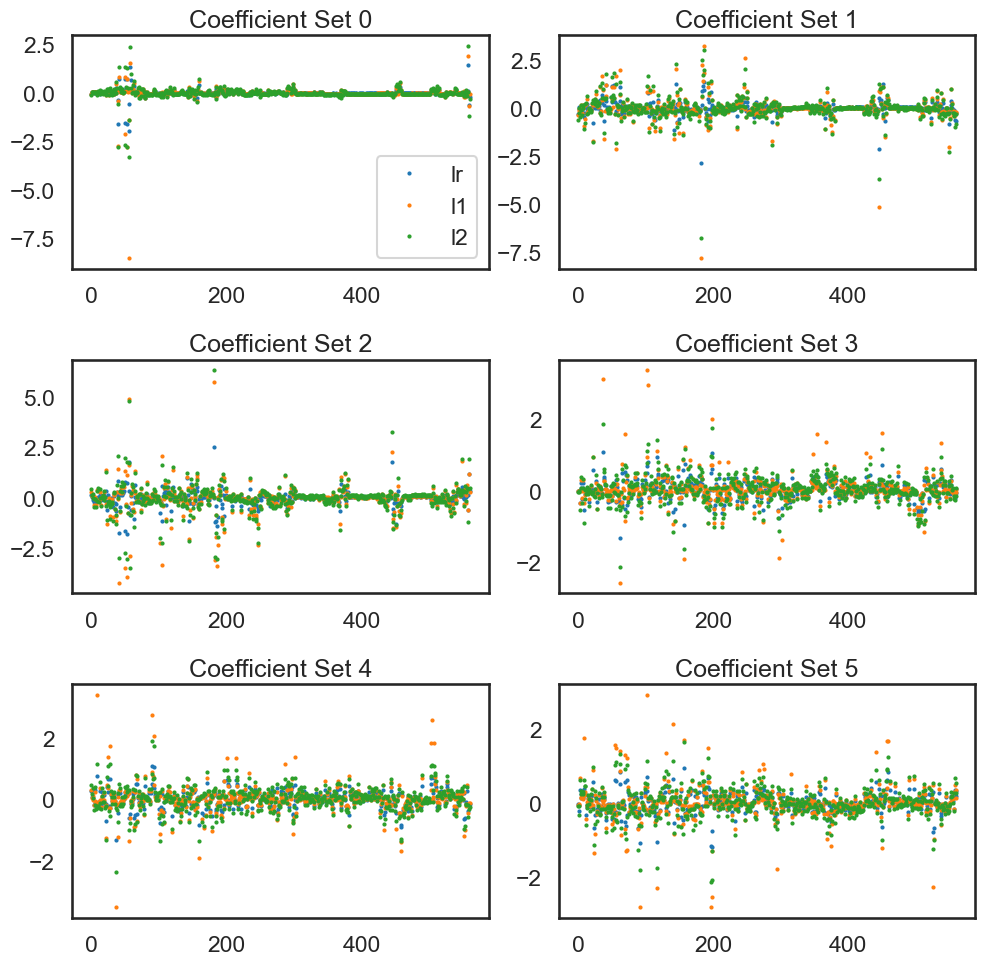

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+ str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

* Predict and store the class for each model.
* Store the probability for the predicted class for each model. 


In [46]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [47]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.999982,1.000000,1.000000
1,0.997816,0.999976,0.999965
2,0.996312,0.999878,0.999808
3,0.987071,0.999623,0.999548
4,0.997708,0.999626,0.999809


## Question 7

For each model, calculate the following error metrics: 

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [48]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [49]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.982518,0.983810,0.983808
recall,0.982524,0.983819,0.983819
fscore,0.982519,0.983812,0.983812
accuracy,0.982524,0.983819,0.983819
auc,0.989421,0.990162,0.990170


## Question 8

* Display or plot the confusion matrix for each model.


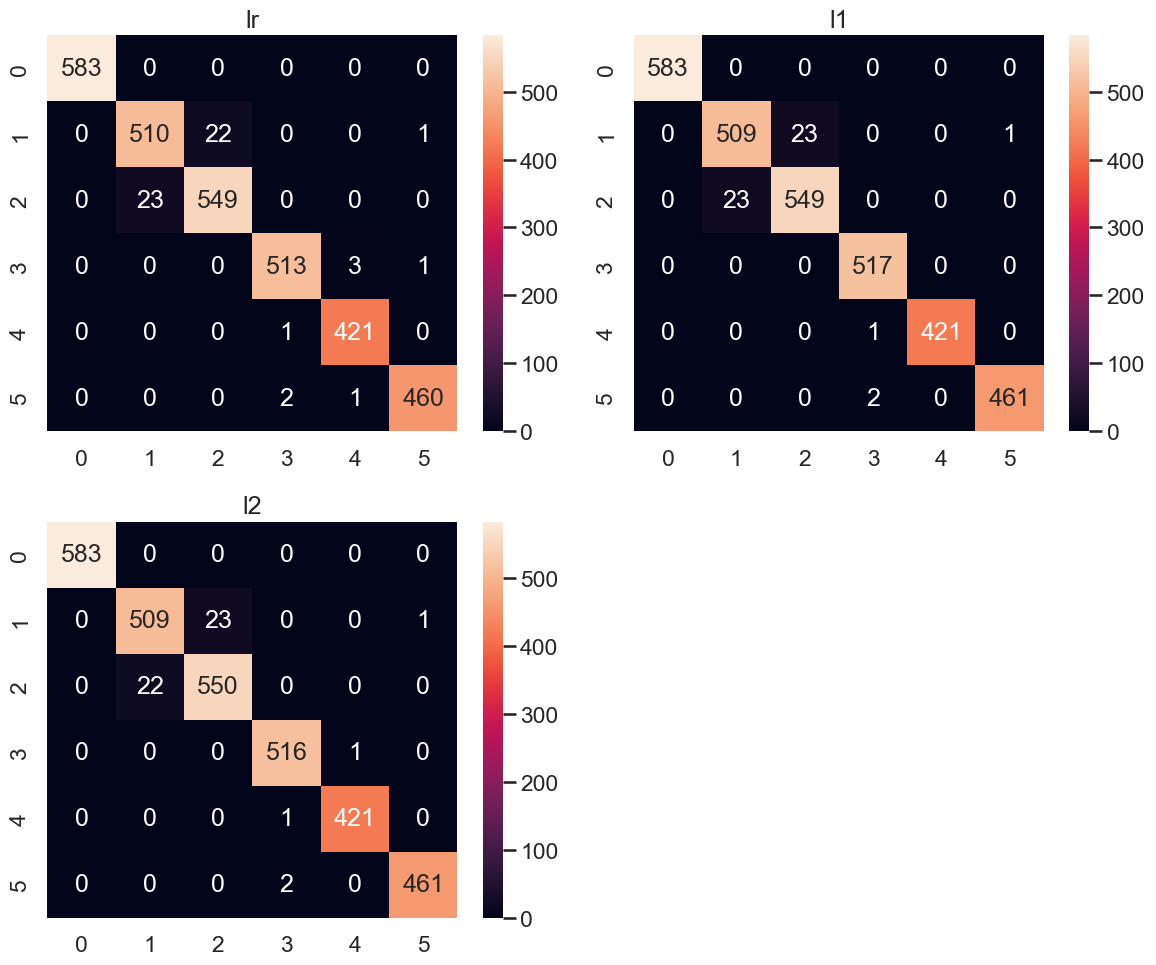

In [50]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation
